In [1]:
import pandas as pd
pd.set_option("display.precision", 8)
from matplotlib import pyplot as plt
import os
from math import pi, log
from matplotlib import rcParams
rcParams["text.usetex"] = True
rcParams["figure.dpi"] = 200
rcParams["font.size"] = 18


def agglomerate_dframe(csv_filename="",study_pattern="",dframe_name=""):
    # Find all "csv_filename.csv" files in study_pattern*/ folders
    csv_files = [os.path.join(folder, csv_filename) 
                 for folder in os.listdir(os.curdir) 
                 if os.path.isfile(os.path.join(folder, csv_filename))
                 and study_pattern in folder]
    csv_files.sort()
    # Read all "csv_filename.csv" files into a pandas.DataFrame
    dframes = []
    for csv_file in csv_files:
        dframes.append(pd.read_csv(csv_file, header=0)) 
    final_dframe = pd.concat(dframes, ignore_index=True)
    final_dframe.to_csv(dframe_name + ".csv", index=False)
    return final_dframe

# Convergence of $|V(t_0) - V_e| \quad V(t_0) := \sum_{c \in C} \alpha_c |\Omega_c|$ $V_e$ is the exact volume, using leiaSetFields.csv 



In [2]:
R = 0.15 # From the test case definition 
A = R**2 * pi
h_mesh = 0.1 # From system/blockMeshDict
V_e = A * h_mesh

marker_dframe = agglomerate_dframe(csv_filename="leiaSetFields.csv",
                                   study_pattern="meshConvergence",
                                   dframe_name="marker")

print ("Exact volume %e" % V_e)
print ("Marker model volume")
print (marker_dframe["VOL_ALPHA_0"])
volume_error = abs(marker_dframe["VOL_ALPHA_0"] - V_e) / V_e
print ("Volume error")
print (volume_error)
plt.plot(marker_dframe["H"], volume_error, '-x')
plt.ylabel("$|V(t_0) - V_e|/|V_e|$")
plt.xlabel("h")
plt.loglog()
plt.savefig("leiaLevelSetFoam-marker-V0-error.pdf", bbox_inches="tight")

ValueError: No objects to concatenate

In [ ]:
plt.plot(marker_dframe["H"], volume_error, '-x', label="Marker field")
h_01 = [marker_dframe["H"].iloc[0],marker_dframe["H"].iloc[-1]]
error2nd_01 = [volume_error.iloc[0], 
            volume_error.iloc[0]*(h_01[1]/h_01[0])**2]
error1st_01 = [volume_error.iloc[0], 
            volume_error.iloc[0]*(h_01[1]/h_01[0])]
plt.plot(h_01,error2nd_01,"k--",label="second-order")
plt.plot(h_01,error1st_01,"r:",label="first-order")
plt.ylabel("$|V(t_0) - V_e|/|V_e|$")
plt.xlabel("h")
plt.loglog()
plt.legend()
plt.savefig("leiaLevelSetFoam-comparison-V0-error.pdf", bbox_inches="tight")

# shear2D verification case

A circle of radius $R=0.15$ is placed in a unit-square domain at $C=(0.75, 0.5)$ and advected with the velocity 

$$
        \mathbf{v} = \cos \left(\frac{\pi t}{T}\right) \left[ \begin{matrix} 
            \sin(2\pi y)\sin^2(\pi x) \\ 
            -\sin(2\pi x)\sin^2(\pi y) \\ 
            0
        \end{matrix}\right]
$$

that reverses the flow after $t=0.5T$. Rate of convergence is reported for the absolute error $|\phi_c^{T} - \phi_c^{0}|$ in the $L_\infty$ norm
$$
             e_\phi^\infty = \max_{c \in C} |\phi^{t_e}_c - \phi^0_c|,
$$
with $t_e = T$ and $C$ being the index-set of all mesh cells. The rate of convergence is computed with respect to the discretization length $h$
$$
                h := \max_{f \in F} \| \mathbf{d}_f \|, 
$$
where $F$ is the index-set of all mesh faces.

# Ev - volume conservation error 

# $$E_v(t)  = \frac{\left|\sum_{c \in C}\alpha_c(t)|\Omega_c| - \sum_{c \in C} \alpha_c(t_0)|\Omega_c|\right|}{\left|\sum_{c \in C} \alpha_c(t_0)|\Omega_c|\right|}$$

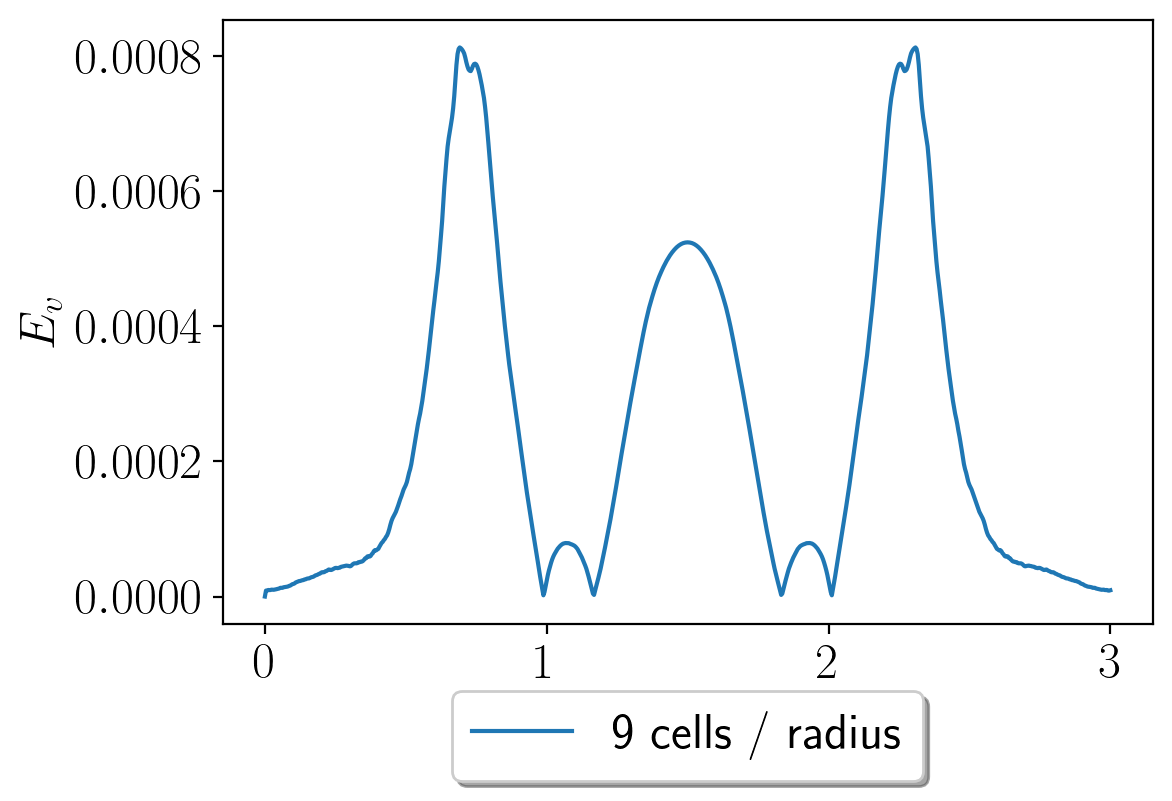

In [4]:
import numpy as np
shear2D_dframe = agglomerate_dframe(csv_filename="leiaLevelSetFoam.csv",
                                    study_pattern="testAdvection",
                                    dframe_name="testAdvection")
resolutions = shear2D_dframe["DELTA_X"].unique()
Evmax = []
for resolution in resolutions:
    resolution_shear2D_data = shear2D_dframe[shear2D_dframe["DELTA_X"] == resolution]
    Evmax.append(resolution_shear2D_data["E_VOL_ALPHA"].max())
    plt.plot(resolution_shear2D_data["TIME"], resolution_shear2D_data["E_VOL_ALPHA"], 
             label="%d cells / radius" % (R * (1 / resolution)))

plt.ylabel("$E_v$")
plt.xlabel("Time in seconds")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07),
          fancybox=True, shadow=True, ncol=2)

In [ ]:
plt.plot(resolutions, Evmax, 'x')
plt.semilogy()
plt.ylabel("$\max(Ev)$")
plt.xlabel("$\Delta x$")

# Eg - L1 Geomeric error 

# $$E_g = \sum_{c \in C} |\Omega_c||\alpha_c(t_e) - \alpha_c(t_0)|$$

In [ ]:
Eg = []
for resolution in resolutions:
    resolution_shear2D_data = shear2D_dframe[shear2D_dframe["DELTA_X"] == resolution]
    Eg.append(resolution_shear2D_data["E_GEOM_ALPHA"].iloc[-1])

print(Eg) 
plt.plot(resolutions, Eg, 
         label="resolution 1 / %d" % (1 / resolution))

# Eb - $L_\infty$ numerical boundedness error 

# $$E_g = \sum_{c \in C} |\Omega_c||\alpha_c(t_e) - \alpha_c(t_0)|$$